## Network from Kell, Yamins, Shook, Norman-Haignere, McDermott, 2018

This notebook shows how to create a tensorflow graph for the network with the weights and biases used in <a href="https://www.cell.com/neuron/fulltext/S0896-6273(18)30250-2">Kell et al., 2018</a>. This notebook also gives an example of how to pass a sound into the network.


### Note on network input

The input to the network is a "cochleagram", a time-frequency decomposition of a sound that is similar to a spectrogram. Below we provide examples of how to pass a pre-computed cochleagram into the network, as well as how to compute the cochleagram for an example wav and then pass that cochleagram to the network.

### Dependencies

Most of the dependencies to run this are relatively standard. However, please note the following:
- This notebook was tested and run with version 1.5.0 of `tensorflow`. It was not tested with other versions.
- `pycochleagram` is a module to generate cochleagrams to pass sounds into the network, which can be found <a href="https://github.com/mcdermottLab/pycochleagram">here</a>.
- `PIL` is the Python Image Library.

### Contact
If you have any questions, please contact Alex Kell. Email: < first_name >< last_name >@mit.edu.

Thanks, and enjoy!

In [1]:
import IPython.display as ipd
from network.branched_network_class import branched_network
import tensorflow as tf
import numpy as np
import scipy.io.wavfile as wav
import librosa

In [2]:
# import the following to run demo_from_wav()
import cochleagram as cgram
from PIL import Image
import matplotlib as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/davidlee/dev/kelletal2018/venv/local/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [3]:
## Some helper functions
def resample(example, new_size):
    im = Image.fromarray(example)
    resized_image = im.resize(new_size, resample=Image.ANTIALIAS)
    return np.array(resized_image)

def plot_cochleagram(cochleagram, title): 
    plt.figure(figsize=(6,3))
    plt.matshow(cochleagram.reshape(256,256), origin='lower',cmap=plt.cm.Blues, fignum=False, aspect='auto')
    plt.yticks([]); plt.xticks([]); plt.title(title); 
    
def play_wav(wav_f, sr, title):   
    print title+':'
    ipd.display(ipd.Audio(wav_f, rate=sr))

In [4]:
word_key = np.load('./demo_stim/logits_to_word_key.npy') # load logits to word key
allowed_words = [
    'also',
    'call',
    'cheese',
    'fresh',
    'into',
    'need',
    'small',
    'store',
    'these',
    'things',
]

for i, word in enumerate(word_key):
    if word in allowed_words:
        print i, word

28 small
78 call
139 things
219 cheese
241 store
263 need
396 these
397 also
514 into
585 fresh


In [5]:
def generate_cochleagram(filename):
    # define parameters
    wav_f, sr = librosa.core.load(filename, sr=16000) # note the sampling rate is 16000hz.
    n = 50
    low_lim, hi_lim = 20, 8000
    sample_factor, pad_factor, downsample = 4, 2, 200
    nonlinearity, fft_mode, ret_mode = 'power', 'auto', 'envs'
    strict = True
    # create cochleagram
    c_gram = cgram.cochleagram(wav_f, sr, n, low_lim, hi_lim, 
                               sample_factor, pad_factor, downsample,
                               nonlinearity, fft_mode, ret_mode, strict)

    # rescale to [0,255]
    c_gram_rescaled =  255*(1-((np.max(c_gram)-c_gram)/np.ptp(c_gram)))
    
    # reshape to (256,256)
    c_gram_reshape_1 = np.reshape(c_gram_rescaled, (211,400))
    c_gram_reshape_2 = resample(c_gram_reshape_1,(256,256))
    plot_cochleagram(c_gram_reshape_2, filename)

    # prepare to run through network -- i.e., flatten it
    c_gram_flatten = np.reshape(c_gram_reshape_2, (1, 256*256)) 

    return c_gram_flatten

In [8]:
import os
'/'.join(os.getcwd().split('/')[:-1])

'/home/davidlee/dev/kelletal2018'

In [11]:
tf.reset_default_graph()
network = branched_network()

word_key = np.load('./demo_stim/logits_to_word_key.npy') # load logits to word key
music_key = np.load('./demo_stim/logits_to_genre_key.npy') # load logits to word key 
        
def demo_from_wav(filename, network):
    # generate cochleagram, then pass cochleagram through network and get logits for word branch
    
    c_gram = generate_cochleagram(filename)
    logits = network.session.run(network.word_logits, feed_dict={network.x: c_gram})
    return logits
#     top_3 = np.argsort(logits, axis=1)[-3:][::-1]
#     print top_3
#     for i in top_3:
#         print word_key[0][i]
#     prediction = word_key[np.argmax(logits, axis=1)]
#     print "Speech Example ... \n clean speech, actual label: Cheese, predicted_label: " \
#         + prediction[0] +'\n'

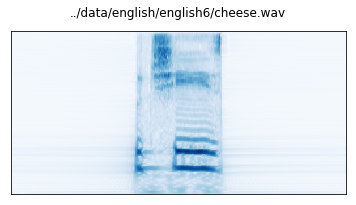

In [11]:
# spanish_logits = demo_from_wav('../data/spanish/spanish1/cheese.wav', network)
# hindi_logits = demo_from_wav('../data/hindi/hindi3/cheese.wav', network)
english_logits = demo_from_wav('../data/english/english6/cheese.wav', network)

In [ ]:
arabic_logits = demo_from_wav('../data/arabic/arabic19/also.wav', network)
# prediction = word_key[np.argmax(logits, axis=1)]
indices = arabic_logits[0].argsort()[-10:]
sorted_words = [word_key[i] for i in indices]
print sorted_words

In [28]:
# prediction = word_key[np.argmax(arabic_logits, axis=1)]
# print prediction
indices = arabic_logits[0].argsort()[-200:]
sorted_words = [word_key[i] for i in indices]
print 'also' in sorted_words

True


In [31]:
# print word_key
# print spanish_logits[0]
for i, word in enumerate(word_key):
    if word == 'cheese':
        print i
        
print "Spanish"
indices = spanish_logits[0].argsort()[-20:]
sorted_words = [word_key[i] for i in indices]
print sorted_words

print "Hindi"
# print hindi_logits[0]
indices = hindi_logits[0].argsort()[-20:]
sorted_words = [word_key[i] for i in indices]
print sorted_words

print "English"
# print hindi_logits[0]
indices = english_logits[0].argsort()[-205:]
sorted_words = [word_key[i] for i in indices]
print 'cheese' in sorted_words

219
Spanish
['change', 'cases', 'country', 'recently', 'taxes', 'recession', 'addition', 'children', 'department', 'changes', 'june', 'association', 'interests', 'used', 'decision', 'issued', 'must', 'shearson', '__genre__', '__null__']
Hindi
['true', 'recession', 'reached', "there's", 'course', 'country', 'used', 'change', 'issued', 'interests', 'changes', 'commission', 'addition', 'huge', 'children', 'june', 'decision', 'must', '__genre__', '__null__']
English
True
